In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [2]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [4]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [5]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [25]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield aug_batch(x, y)

In [8]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [9]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [10]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [11]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    
    mul = 4
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=True
    ))(y)
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=False
    ))(y)
    
    y = layers.Dense(
        units=filters * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [12]:
class CyclicLR(callbacks.Callback):

    def __init__(self, max_lr):
        super().__init__()

        self.max_lr = max_lr
        
        self.steps = None
        self.epochs = None
        
        self.iterations = 0
        self.history = {}
        
    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
     
        self.steps = self.params["steps"]
        self.epochs = self.params["epochs"]
        
        lr = 2 / self.steps / self.epochs
        
        K.set_value(self.model.optimizer.lr, lr)
        
    def clr(self):
        cycle = 2 * self.iterations / self.steps / self.epochs
        
        if cycle <= 1:
            return self.max_lr * cycle
        
        return self.max_lr - self.max_lr * (cycle - 1)
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nLearning rate: {K.get_value(self.model.optimizer.lr):.1e}")
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [13]:
class DecayingCyclicLR(callbacks.Callback):

    def __init__(self, max_lr, half=4, decay=0.5):
        super().__init__()

        self.max_lr = max_lr
        self.half = half
        self.decay = decay
        
        self.steps = None
        self.epochs = None
        
        self.iterations = 0
        self.history = {}
        
    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
     
        self.steps = self.params["steps"]
        self.epochs = self.params["epochs"]
        
        lr = 1 / self.steps / self.half
        
        K.set_value(self.model.optimizer.lr, lr)
        
    def clr(self):
        num, cycle = divmod(self.iterations / (self.steps * self.half), 2)
        
        if cycle <= 1:
            return self.max_lr * cycle * self.decay ** num
        
        return (self.max_lr - self.max_lr * (cycle - 1)) * self.decay ** num
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nLearning rate: {K.get_value(self.model.optimizer.lr):.1e}")
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [12]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [24]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0
        self.d_loss = 0
        self.d_iterations = 0
        self.d_iterations2 = 0
        self.d_1 = 0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}\n")
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [31]:
class ValDecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.val_pre = None
        self.max_speed = None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0
        self.d_loss = 0
        self.d_iterations = 0
        self.d_iterations2 = 0
        self.d_1 = 0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.val_pre = None
        self.max_speed = 0
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > self.max_speed:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs["val_loss"]
        if self.val_pre and val_loss > self.val_pre:
            self.max_speed = self.val_pre - val_loss 
        else:
            self.max_speed = 0
        self.val_pre = val_loss
            
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        print(f"Target Speed: {self.max_speed:.4f}\n")
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [18]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr = 2.6e-03
    
    steps = 40000
    steps_per_epoch = 1000
    epochs = steps // steps_per_epoch
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [20]:
FOLDS = 10

def train_oof(train_set, test_set, units=16):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {np.std(scores):0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68    

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 15s 15ms/step - loss: -0.2606 - val_loss: -0.3858

Epoch 00001: val_loss improved from inf to -0.38577, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.2301
Epoch 2/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3496 - val_loss: -0.3957

Epoch 00002: val_loss improved from -0.38577 to -0.39566, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0937
Epoch 3/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.3956 - val_loss: -0.3959

Epoch 00003: val_loss improved from -0.39566 to -0.39586, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0481
Epoch 4/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4126 - val_loss: -0.4575

Epoch 00004: val_loss improved from -0.39586 to -0.45750, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0319
Epoch 5/

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5617 - val_loss: -0.5748

Epoch 00038: val_loss did not improve from -0.57759

Learning rate: 1.4e-04
Speed per epoch: -0.0003
Epoch 39/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5818 - val_loss: -0.5718

Epoch 00039: val_loss did not improve from -0.57759

Learning rate: 1.4e-04
Speed per epoch: -0.0078
Epoch 40/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5721 - val_loss: -0.5762

Epoch 00040: val_loss did not improve from -0.57759

Learning rate: 1.4e-04
Speed per epoch: 0.0017

Fold - 2 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
_________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 15s 15ms/step - loss: -0.2874 - val_loss: -0.2939

Epoch 00001: val_loss improved from inf to -0.29392, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1516
Epoch 2/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.3714 - val_loss: -0.4020

Epoch 00002: val_loss improved from -0.29392 to -0.40196, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0690
Epoch 3/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.4065 - val_loss: -0.4087

Epoch 00003: val_loss improved from -0.40196 to -0.40868, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0413
Epoch 4/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.4346 - val_loss: -0.4396

Epoch 00004: val_loss improved from -0.40868 to -0.43962, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0353
Epoch 5/

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5716 - val_loss: -0.5385

Epoch 00038: val_loss did not improve from -0.54079

Learning rate: 1.1e-04
Speed per epoch: -0.0025
Epoch 39/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5688 - val_loss: -0.5388

Epoch 00039: val_loss did not improve from -0.54079

Learning rate: 7.4e-05
Speed per epoch: 0.0021
Epoch 40/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5771 - val_loss: -0.5371

Epoch 00040: val_loss did not improve from -0.54079

Learning rate: 5.2e-05
Speed per epoch: -0.0024

Fold - 3 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
_________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 14s 14ms/step - loss: -0.2751 - val_loss: -0.3808

Epoch 00001: val_loss improved from inf to -0.38075, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1627
Epoch 2/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3610 - val_loss: -0.3770

Epoch 00002: val_loss did not improve from -0.38075

Learning rate: 2.6e-03
Speed per epoch: -0.0667
Epoch 3/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3880 - val_loss: -0.4993

Epoch 00003: val_loss improved from -0.38075 to -0.49934, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0425
Epoch 4/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4264 - val_loss: -0.4558

Epoch 00004: val_loss did not improve from -0.49934

Learning rate: 2.6e-03
Speed per epoch: -0.0348
Epoch 5/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4138 - val_loss

1000/1000 [==============================] - 12s 12ms/step - loss: -0.5640 - val_loss: -0.5765

Epoch 00037: val_loss improved from -0.57611 to -0.57648, saving model to ../processed/model.h5

Learning rate: 1.3e-04
Speed per epoch: -0.0015
Epoch 38/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5783 - val_loss: -0.5773

Epoch 00038: val_loss improved from -0.57648 to -0.57729, saving model to ../processed/model.h5

Learning rate: 1.3e-04
Speed per epoch: -0.0046
Epoch 39/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5663 - val_loss: -0.5792

Epoch 00039: val_loss improved from -0.57729 to -0.57921, saving model to ../processed/model.h5

Learning rate: 8.9e-05
Speed per epoch: 0.0024
Epoch 40/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5809 - val_loss: -0.5814

Epoch 00040: val_loss improved from -0.57921 to -0.58136, saving model to ../processed/model.h5

Learning rate: 6.9e-05
Speed per epoch: -0.0044



/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 15s 15ms/step - loss: -0.3020 - val_loss: -0.4019

Epoch 00001: val_loss improved from inf to -0.40185, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1241
Epoch 2/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3845 - val_loss: -0.3656

Epoch 00002: val_loss did not improve from -0.40185

Learning rate: 2.6e-03
Speed per epoch: -0.0732
Epoch 3/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4117 - val_loss: -0.4112

Epoch 00003: val_loss improved from -0.40185 to -0.41119, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0431
Epoch 4/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4295 - val_loss: -0.4465

Epoch 00004: val_loss improved from -0.41119 to -0.44649, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0275
Epoch 5/40
1000/1000 [==============================

1000/1000 [==============================] - 12s 12ms/step - loss: -0.5598 - val_loss: -0.5412

Epoch 00038: val_loss did not improve from -0.54743

Learning rate: 1.7e-04
Speed per epoch: -0.0011
Epoch 39/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5672 - val_loss: -0.5439

Epoch 00039: val_loss did not improve from -0.54743

Learning rate: 1.4e-04
Speed per epoch: -0.0027
Epoch 40/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5747 - val_loss: -0.5315

Epoch 00040: val_loss did not improve from -0.54743

Learning rate: 1.4e-04
Speed per epoch: -0.0055

Fold - 5 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 15s 15ms/step - loss: -0.2494 - val_loss: -0.2331

Epoch 00001: val_loss improved from inf to -0.23305, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.2223
Epoch 2/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3607 - val_loss: -0.3682

Epoch 00002: val_loss improved from -0.23305 to -0.36820, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1060
Epoch 3/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4014 - val_loss: -0.4156

Epoch 00003: val_loss improved from -0.36820 to -0.41563, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0607
Epoch 4/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.4107 - val_loss: -0.3557

Epoch 00004: val_loss did not improve from -0.41563

Learning rate: 2.6e-03
Speed per epoch: -0.0272
Epoch 5/40
1000/1000 [==============================

1000/1000 [==============================] - 13s 13ms/step - loss: -0.5583 - val_loss: -0.5309

Epoch 00037: val_loss improved from -0.51975 to -0.53088, saving model to ../processed/model.h5

Learning rate: 5.3e-05
Speed per epoch: 0.0040
Epoch 38/40
1000/1000 [==============================] - 13s 13ms/step - loss: -0.5807 - val_loss: -0.5310

Epoch 00038: val_loss improved from -0.53088 to -0.53100, saving model to ../processed/model.h5

Learning rate: 4.1e-05
Speed per epoch: -0.0022
Epoch 39/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5807 - val_loss: -0.5276

Epoch 00039: val_loss did not improve from -0.53100

Learning rate: 4.1e-05
Speed per epoch: -0.0041
Epoch 40/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5721 - val_loss: -0.5315

Epoch 00040: val_loss improved from -0.53100 to -0.53151, saving model to ../processed/model.h5

Learning rate: 2.7e-05
Speed per epoch: 0.0004

Fold - 6 / 10
_______________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 15s 15ms/step - loss: -0.2969 - val_loss: -0.3462

Epoch 00001: val_loss improved from inf to -0.34624, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1335
Epoch 2/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.3876 - val_loss: -0.3939

Epoch 00002: val_loss improved from -0.34624 to -0.39393, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0824
Epoch 3/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4046 - val_loss: -0.4429

Epoch 00003: val_loss improved from -0.39393 to -0.44288, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0238
Epoch 4/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.4375 - val_loss: -0.4137

Epoch 00004: val_loss did not improve from -0.44288

Learning rate: 2.6e-03
Speed per epoch: -0.0271
Epoch 5/40
1000/1000 [==============================

1000/1000 [==============================] - 12s 12ms/step - loss: -0.5618 - val_loss: -0.5344

Epoch 00038: val_loss did not improve from -0.55019

Learning rate: 2.6e-04
Speed per epoch: -0.0026
Epoch 39/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5577 - val_loss: -0.5405

Epoch 00039: val_loss did not improve from -0.55019

Learning rate: 2.0e-04
Speed per epoch: 0.0025
Epoch 40/40
1000/1000 [==============================] - 12s 12ms/step - loss: -0.5688 - val_loss: -0.5500

Epoch 00040: val_loss did not improve from -0.55019

Learning rate: 1.4e-04
Speed per epoch: -0.0037

Fold - 7 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         35328     
_________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 18s 18ms/step - loss: -0.2941 - val_loss: -0.3610

Epoch 00001: val_loss improved from inf to -0.36099, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1601
Epoch 2/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.3644 - val_loss: -0.3055

Epoch 00002: val_loss did not improve from -0.36099

Learning rate: 2.6e-03
Speed per epoch: -0.0713
Epoch 3/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.4009 - val_loss: -0.4307

Epoch 00003: val_loss improved from -0.36099 to -0.43074, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0422
Epoch 4/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.4127 - val_loss: -0.4599

Epoch 00004: val_loss improved from -0.43074 to -0.45989, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0198
Epoch 5/40
1000/1000 [==============================

1000/1000 [==============================] - 16s 16ms/step - loss: -0.5684 - val_loss: -0.5739

Epoch 00037: val_loss did not improve from -0.57792

Learning rate: 1.3e-04
Speed per epoch: -0.0001
Epoch 38/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5631 - val_loss: -0.5791

Epoch 00038: val_loss improved from -0.57792 to -0.57911, saving model to ../processed/model.h5

Learning rate: 4.6e-05
Speed per epoch: 0.0012
Epoch 39/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5781 - val_loss: -0.5790

Epoch 00039: val_loss did not improve from -0.57911

Learning rate: 3.2e-05
Speed per epoch: -0.0041
Epoch 40/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.5735 - val_loss: -0.5784

Epoch 00040: val_loss did not improve from -0.57911

Learning rate: 2.9e-05
Speed per epoch: -0.0015

Fold - 8 / 10
_________________________________________________________________
Layer (type)                 Output Shape           

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 19s 19ms/step - loss: -0.2941 - val_loss: -0.2769

Epoch 00001: val_loss improved from inf to -0.27687, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1813
Epoch 2/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.3579 - val_loss: -0.3677

Epoch 00002: val_loss improved from -0.27687 to -0.36768, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0578
Epoch 3/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.3892 - val_loss: -0.3730

Epoch 00003: val_loss improved from -0.36768 to -0.37296, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0340
Epoch 4/40
1000/1000 [==============================] - 14s 14ms/step - loss: -0.4035 - val_loss: -0.3749

Epoch 00004: val_loss improved from -0.37296 to -0.37486, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0250
Epoch 5/

1000/1000 [==============================] - 16s 16ms/step - loss: -0.5621 - val_loss: -0.5570

Epoch 00037: val_loss improved from -0.54582 to -0.55697, saving model to ../processed/model.h5

Learning rate: 1.1e-04
Speed per epoch: -0.0010
Epoch 38/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5760 - val_loss: -0.5450

Epoch 00038: val_loss did not improve from -0.55697

Learning rate: 1.1e-04
Speed per epoch: -0.0051
Epoch 39/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5824 - val_loss: -0.5520

Epoch 00039: val_loss did not improve from -0.55697

Learning rate: 1.1e-04
Speed per epoch: -0.0075
Epoch 40/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.5694 - val_loss: -0.5514

Epoch 00040: val_loss did not improve from -0.55697

Learning rate: 9.6e-05
Speed per epoch: 0.0020

Fold - 9 / 10
_________________________________________________________________
Layer (type)                 Output Shape           

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars


1000/1000 [==============================] - 19s 19ms/step - loss: -0.2868 - val_loss: -0.2261

Epoch 00001: val_loss improved from inf to -0.22608, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1507
Epoch 2/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.3647 - val_loss: -0.2350

Epoch 00002: val_loss improved from -0.22608 to -0.23503, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0648
Epoch 3/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.3734 - val_loss: -0.3961

Epoch 00003: val_loss improved from -0.23503 to -0.39611, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0271
Epoch 4/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.4202 - val_loss: -0.4016

Epoch 00004: val_loss improved from -0.39611 to -0.40156, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0340
Epoch 5/

1000/1000 [==============================] - 16s 16ms/step - loss: -0.5618 - val_loss: -0.5313

Epoch 00037: val_loss did not improve from -0.53287

Learning rate: 6.6e-05
Speed per epoch: 0.0003
Epoch 38/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5704 - val_loss: -0.5340

Epoch 00038: val_loss improved from -0.53287 to -0.53400, saving model to ../processed/model.h5

Learning rate: 4.9e-05
Speed per epoch: -0.0012
Epoch 39/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5688 - val_loss: -0.5347

Epoch 00039: val_loss improved from -0.53400 to -0.53475, saving model to ../processed/model.h5

Learning rate: 2.7e-05
Speed per epoch: -0.0044
Epoch 40/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5850 - val_loss: -0.5359

Epoch 00040: val_loss improved from -0.53475 to -0.53592, saving model to ../processed/model.h5

Learning rate: 2.7e-05
Speed per epoch: -0.0083

Fold - 10 / 10
_____________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 20s 20ms/step - loss: -0.2762 - val_loss: -0.3249

Epoch 00001: val_loss improved from inf to -0.32491, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.1046
Epoch 2/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.3531 - val_loss: -0.3425

Epoch 00002: val_loss improved from -0.32491 to -0.34252, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0734
Epoch 3/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.3958 - val_loss: -0.4255

Epoch 00003: val_loss improved from -0.34252 to -0.42554, saving model to ../processed/model.h5

Learning rate: 2.6e-03
Speed per epoch: -0.0555
Epoch 4/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.3882 - val_loss: -0.4042

Epoch 00004: val_loss did not improve from -0.42554

Learning rate: 2.6e-03
Speed per epoch: -0.0214
Epoch 5/40
1000/1000 [==============================


Epoch 00037: val_loss did not improve from -0.53490

Learning rate: 2.3e-04
Speed per epoch: -0.0048
Epoch 38/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.5668 - val_loss: -0.5325

Epoch 00038: val_loss did not improve from -0.53490

Learning rate: 2.3e-04
Speed per epoch: -0.0030
Epoch 39/40
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5758 - val_loss: -0.5352

Epoch 00039: val_loss improved from -0.53490 to -0.53518, saving model to ../processed/model.h5

Learning rate: 2.3e-04
Speed per epoch: -0.0046
Epoch 40/40
1000/1000 [==============================] - 15s 15ms/step - loss: -0.5675 - val_loss: -0.5335

Epoch 00040: val_loss did not improve from -0.53518

Learning rate: 1.6e-04
Speed per epoch: 0.0001
IOU на кроссвалидации: [0.58136 0.57911 0.57759 0.55697 0.55019 0.54743 0.54079 0.53592 0.53518
 0.53151]
IOU среднее: 0.55361 +/- 0.01833


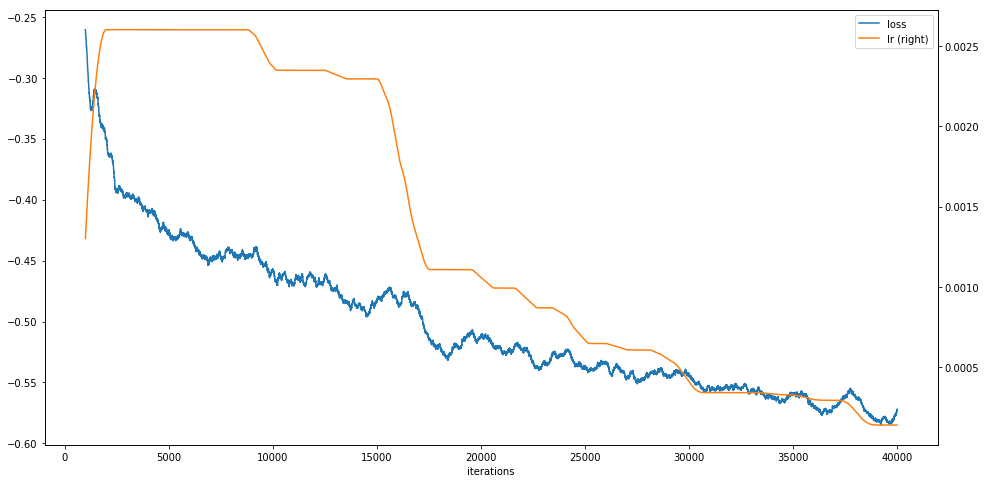

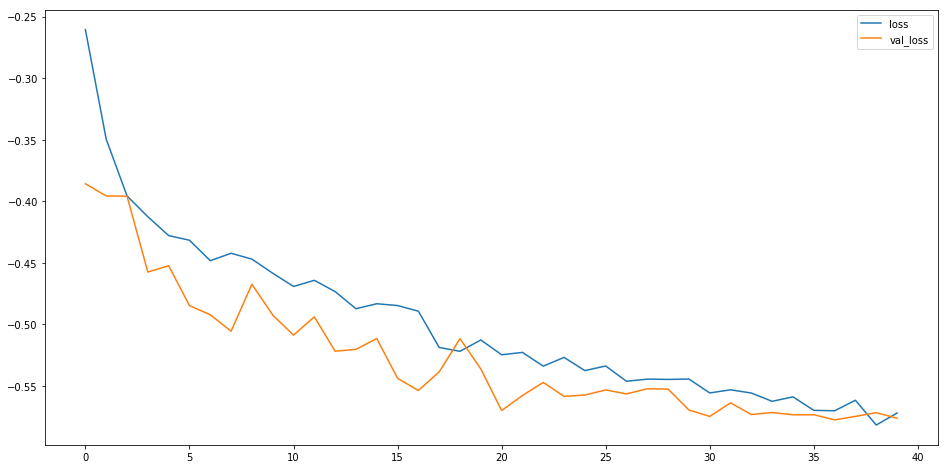

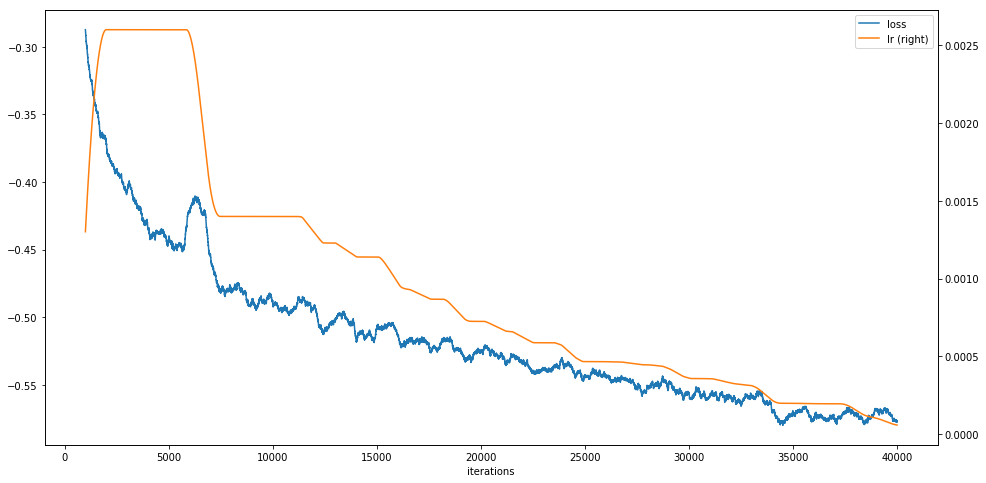

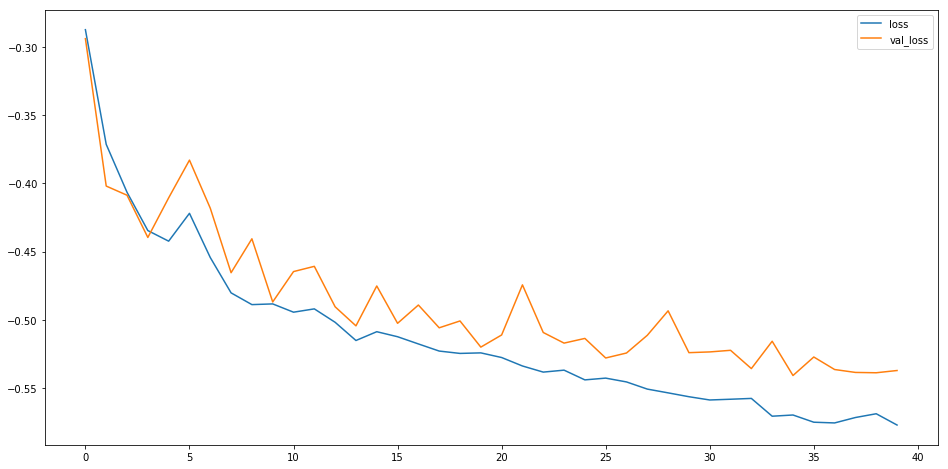

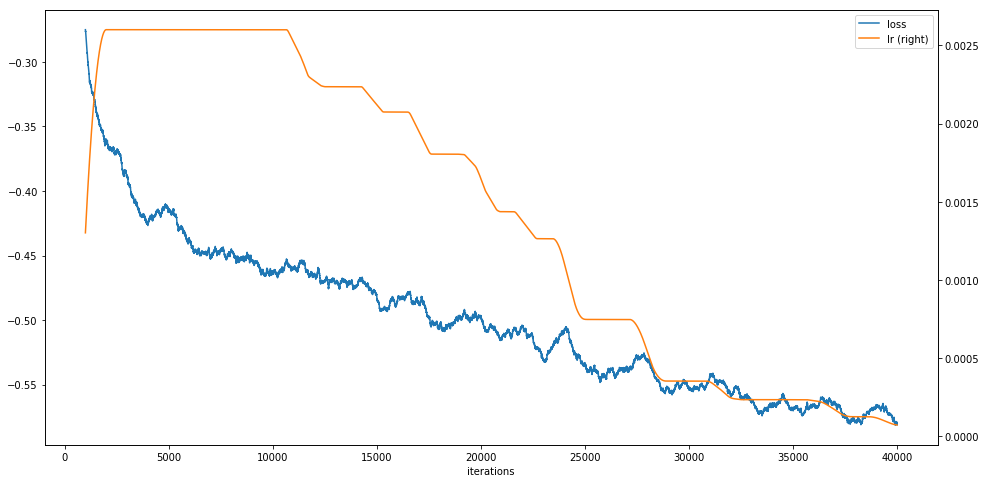

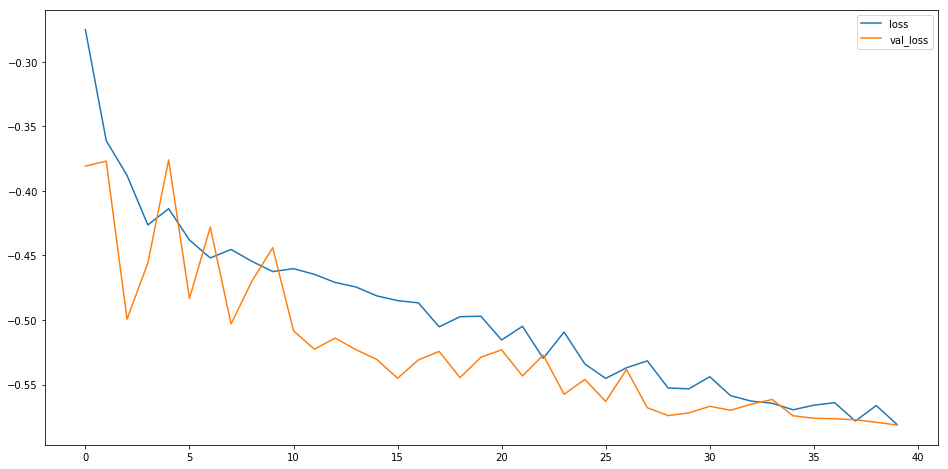

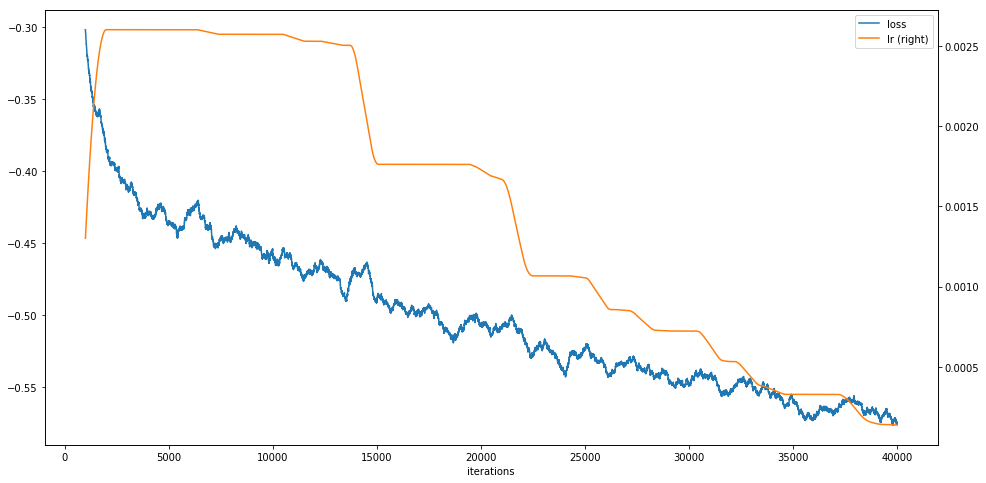

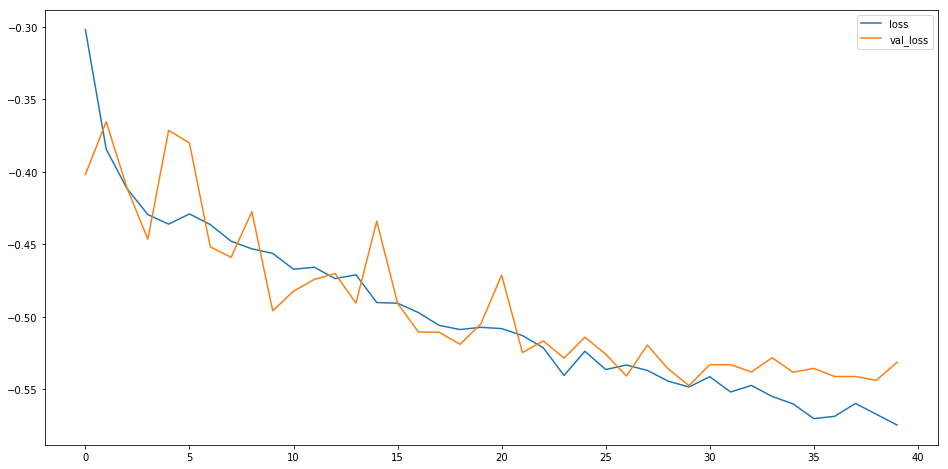

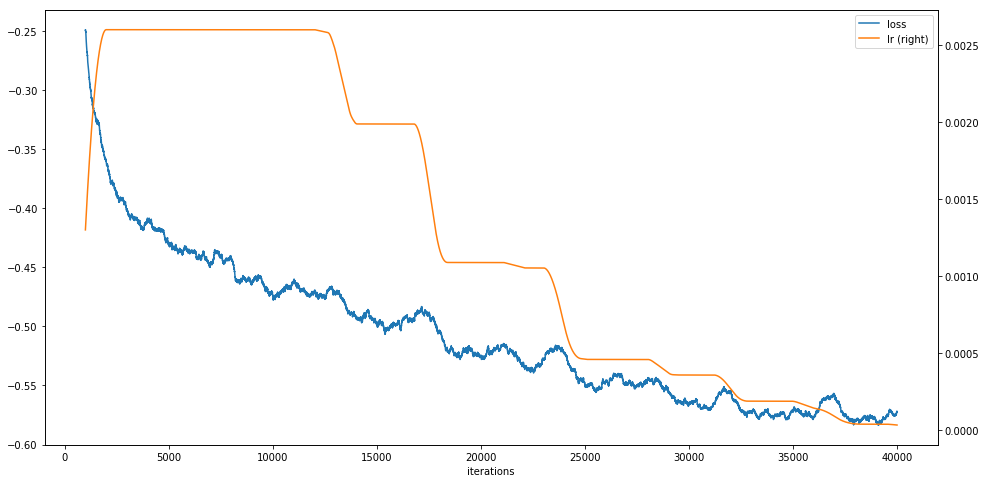

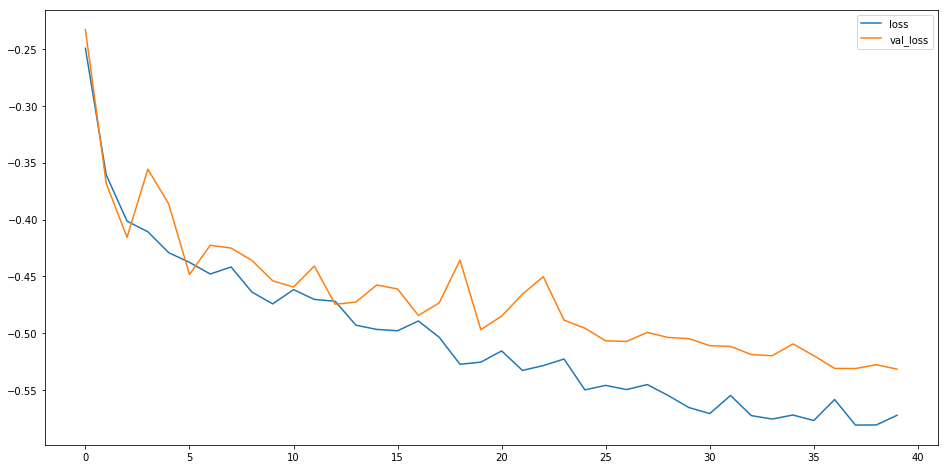

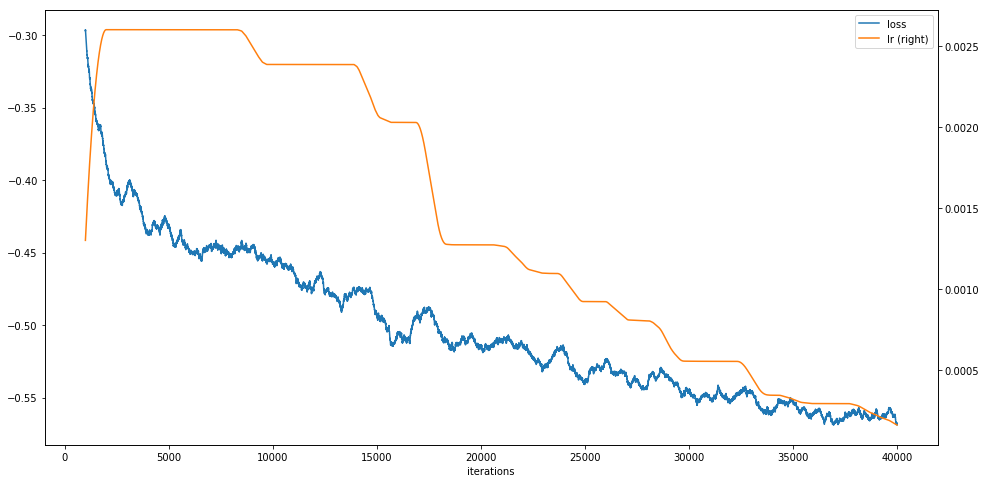

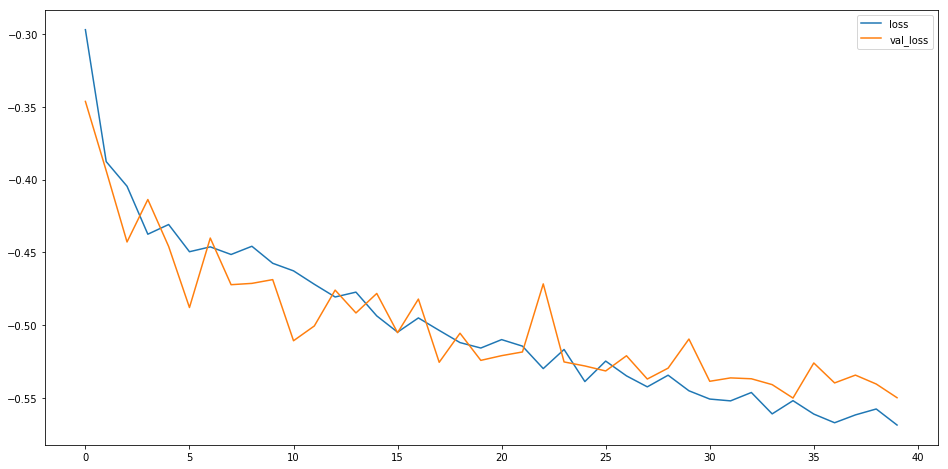

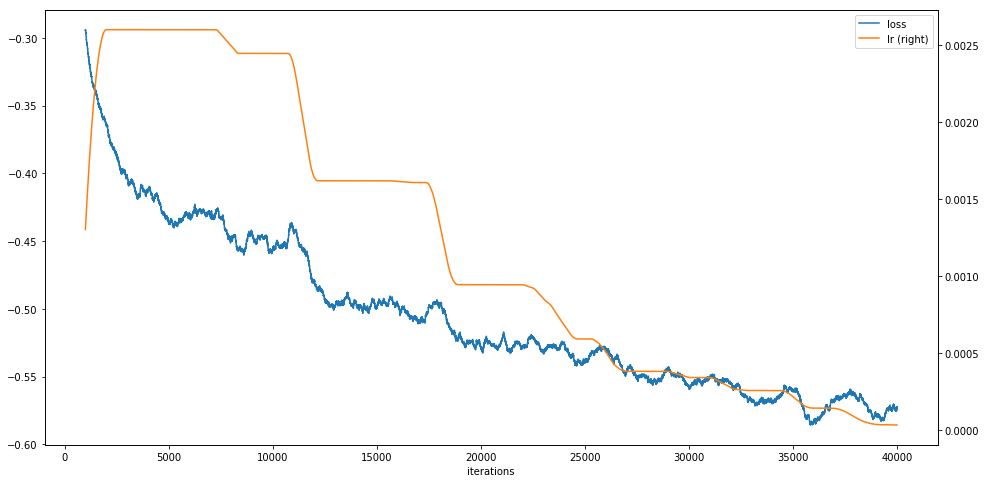

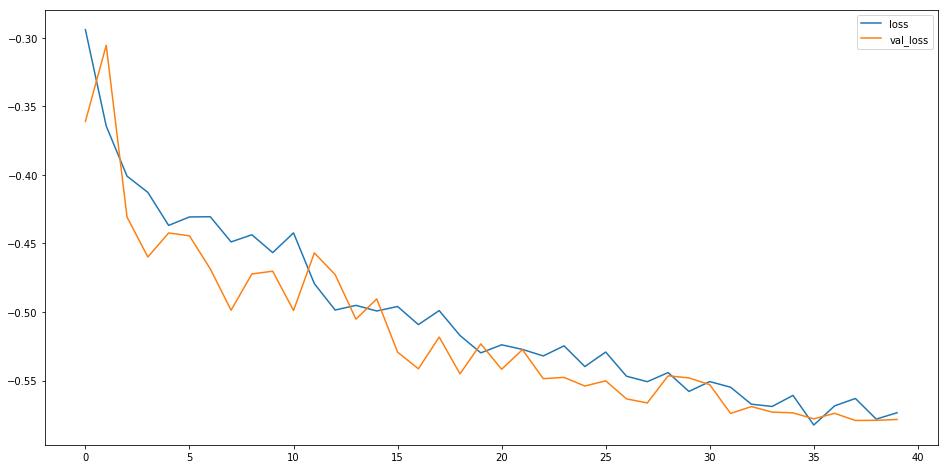

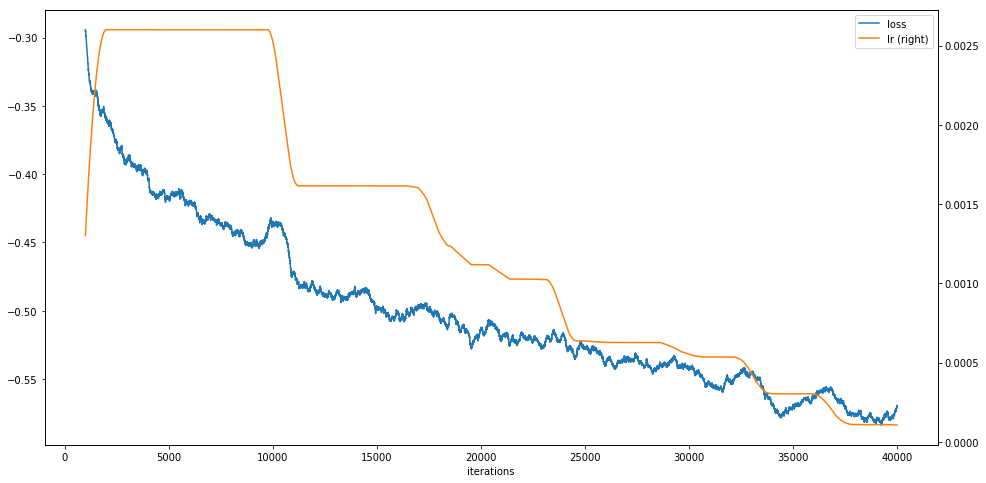

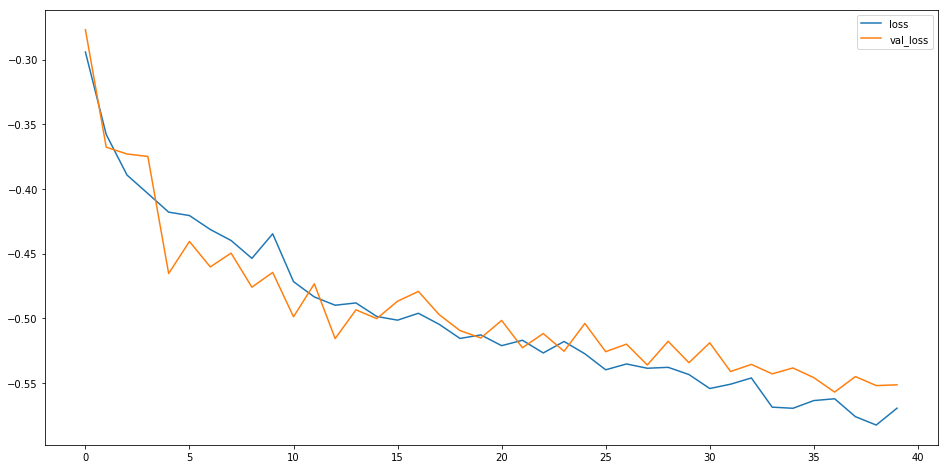

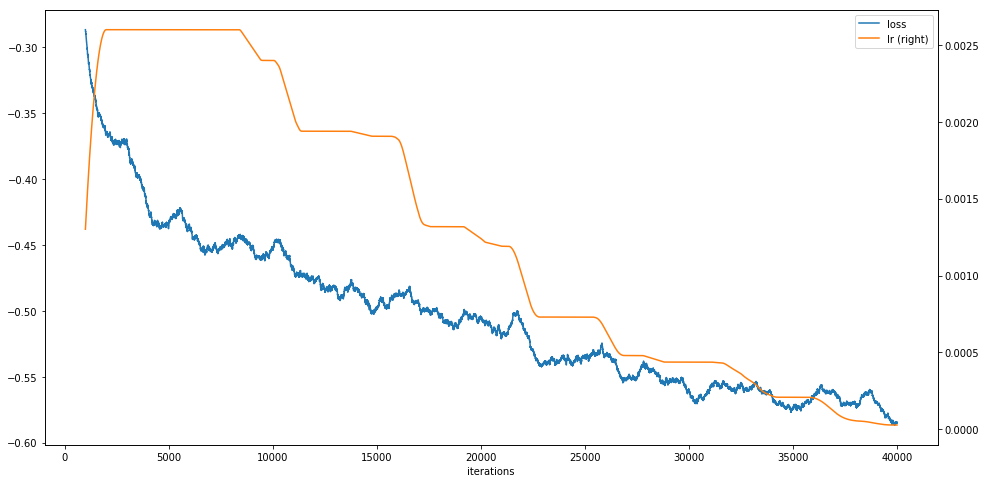

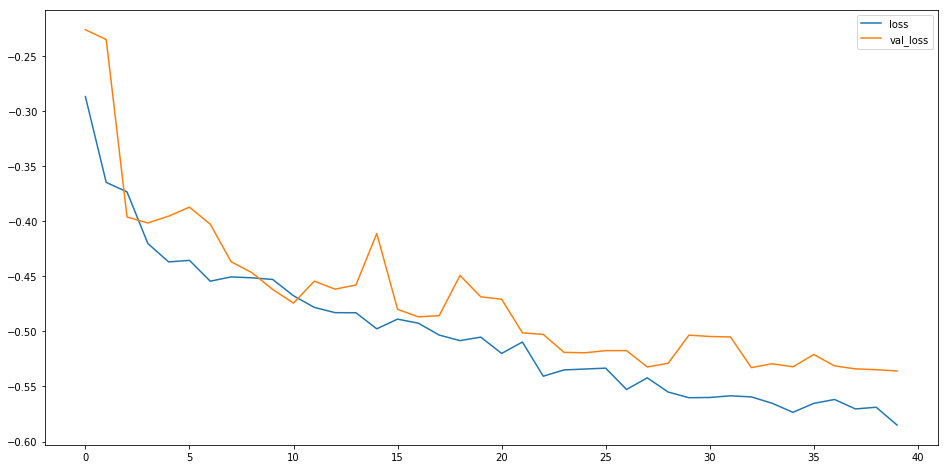

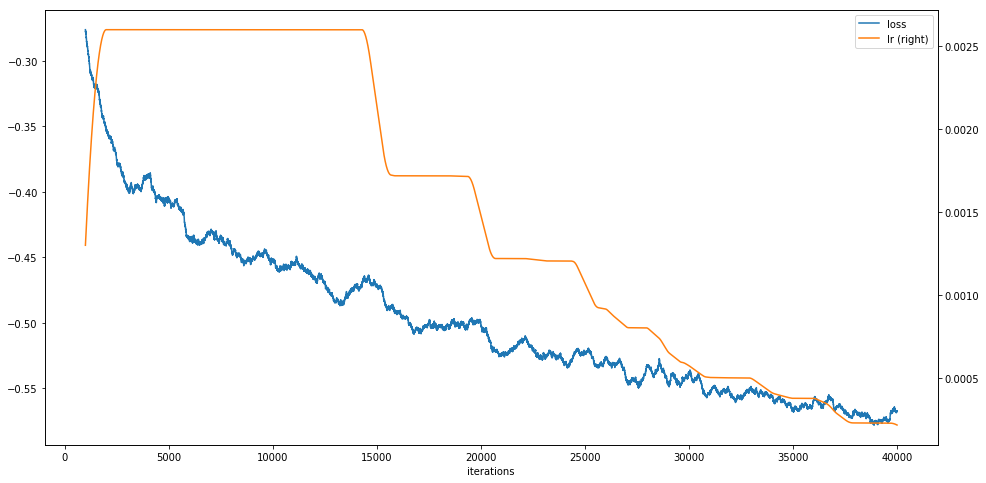

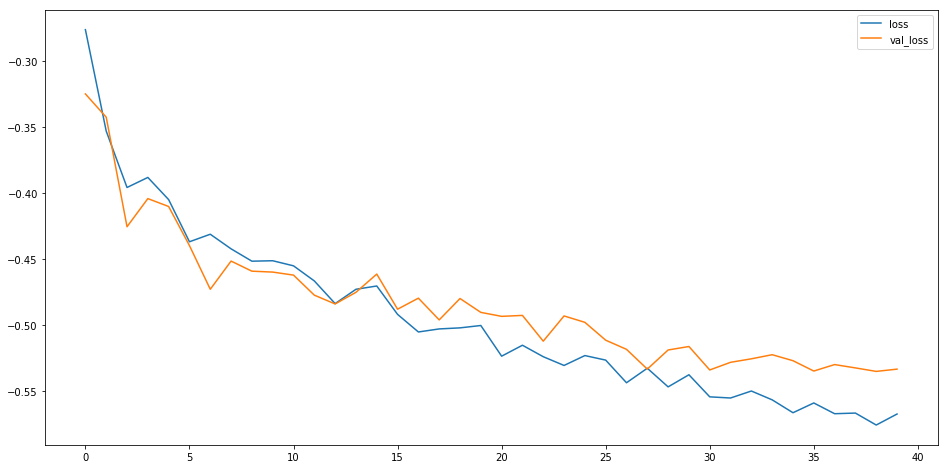

In [23]:
train_oof((votes, answers), votes_test)